Enhanced Iris Analysis System
Loading models...


c:\Users\dell\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Facial landmark predictor not found. Using basic eye detection.
Capturing image...
Looking for a high-quality image...
Could not capture high quality image. Best: 0.25
Analyzing iris...
Analyzing Left Eye...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Analyzing Right Eye...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
  Low quality image for Right Eye. Skipping detailed analysis.


C:\Users\dell\AppData\Local\Temp\ipykernel_20472\1796001439.py:457: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1, 2].legend()


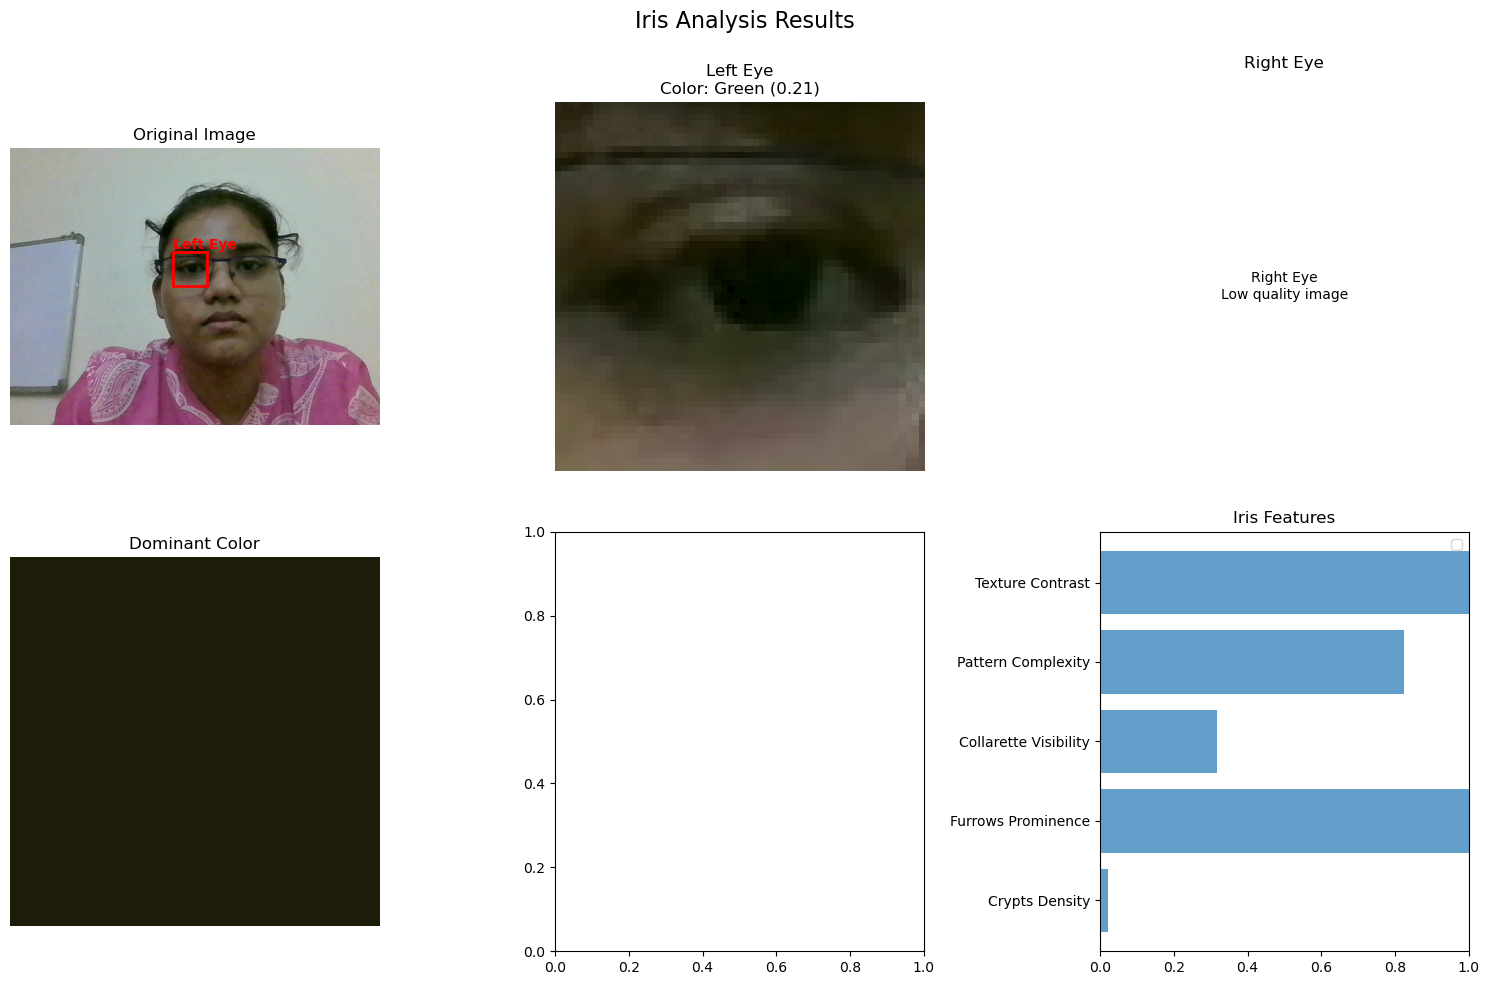


DETAILED ANALYSIS RESULTS

Left Eye:
  Color: Green (confidence: 0.21)
  Image Quality: 0.33
  Features:
    - Crypts Density: 0.02
    - Furrows Prominence: 1.93
    - Collarette Visibility: 0.32
    - Pattern Complexity: 0.82
    - Texture Contrast: 27.78

Right Eye:
  Error: Low quality image

Analysis complete!


In [2]:
# enhanced_iris_analysis.py
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.preprocessing import image
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import dlib
import os
import time
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Create directories for models and data if they don't exist
os.makedirs('models', exist_ok=True)
os.makedirs('data', exist_ok=True)

# Improved iris segmentation model (U-Net architecture)
def create_iris_segmentation_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)
    
    # Downsample path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Bottom
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    
    # Upsample path
    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)
    
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)
    
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)
    
    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create and compile models (in a real scenario, you would load pre-trained models)
def load_or_create_models():
    # Create iris segmentation model
    segmentation_model = create_iris_segmentation_model()
    segmentation_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Create color classification model (simplified CNN)
    color_model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')  # 5 color classes
    ])
    color_model.compile(optimizer='adam', 
                       loss='sparse_categorical_crossentropy', 
                       metrics=['accuracy'])
    
    # Load face detector
    detector = dlib.get_frontal_face_detector()
    
    # Load facial landmark predictor
    try:
        predictor = dlib.shape_predictor("models/shape_predictor_68_face_landmarks.dat")
    except:
        print("Facial landmark predictor not found. Using basic eye detection.")
        predictor = None
        
    return segmentation_model, color_model, detector, predictor

# Enhanced image preprocessing
def preprocess_image(img, target_size=(128, 128)):
    # Resize image
    img = cv2.resize(img, target_size)
    
    # Normalize pixel values
    img = img.astype('float32') / 255.0
    
    # Apply histogram equalization to enhance contrast
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist((img_yuv[:,:,0] * 255).astype('uint8')) / 255.0
    img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    
    return img

# Enhanced iris segmentation using U-Net
def segment_iris(image, model):
    # Preprocess image
    input_img = preprocess_image(image)
    input_img = np.expand_dims(input_img, axis=0)
    
    # Predict segmentation mask
    mask = model.predict(input_img)[0]
    
    # Threshold mask to binary
    mask = (mask > 0.5).astype('uint8')
    
    return mask

# Enhanced eye detection with fallback
def detect_eyes(image, detector, predictor):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Try to use facial landmarks for precise eye detection
    if predictor is not None:
        faces = detector(gray)
        if len(faces) > 0:
            face = faces[0]
            landmarks = predictor(gray, face)
            
            # Left eye landmarks (points 36 to 41)
            left_eye_points = []
            for n in range(36, 42):
                x = landmarks.part(n).x
                y = landmarks.part(n).y
                left_eye_points.append((x, y))
            
            # Right eye landmarks (points 42 to 47)
            right_eye_points = []
            for n in range(42, 48):
                x = landmarks.part(n).x
                y = landmarks.part(n).y
                right_eye_points.append((x, y))
            
            return left_eye_points, right_eye_points
    
    # Fallback: Use Haar cascades for eye detection
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    eyes = eye_cascade.detectMultiScale(gray, 1.3, 5)
    
    if len(eyes) >= 2:
        # Sort eyes by x-position and assume left and right eyes
        eyes = sorted(eyes, key=lambda x: x[0])
        left_eye = eyes[0]
        right_eye = eyes[1]
        
        # Convert to points format
        lx, ly, lw, lh = left_eye
        left_eye_points = [(lx, ly), (lx+lw, ly), (lx+lw, ly+lh), (lx, ly+lh)]
        
        rx, ry, rw, rh = right_eye
        right_eye_points = [(rx, ry), (rx+rw, ry), (rx+rw, ry+rh), (rx, ry+rh)]
        
        return left_eye_points, right_eye_points
    
    # Final fallback: Use image quarters as eye regions
    height, width = image.shape[:2]
    left_eye_points = [(width//4, height//3), (width//2, height//3), 
                       (width//2, 2*height//3), (width//4, 2*height//3)]
    right_eye_points = [(width//2, height//3), (3*width//4, height//3), 
                        (3*width//4, 2*height//3), (width//2, 2*height//3)]
    
    return left_eye_points, right_eye_points

# Enhanced iris extraction with segmentation
def extract_iris_region(image, eye_points, segmentation_model):
    # Get bounding box of the eye
    x_coords = [p[0] for p in eye_points]
    y_coords = [p[1] for p in eye_points]
    x, y = min(x_coords), min(y_coords)
    w, h = max(x_coords) - x, max(y_coords) - y
    
    # Expand the region slightly
    expand = 5
    x = max(0, x - expand)
    y = max(0, y - expand)
    w = min(image.shape[1] - x, w + 2*expand)
    h = min(image.shape[0] - y, h + 2*expand)
    
    # Extract the eye region
    eye_region = image[y:y+h, x:x+w]
    
    # Segment iris within the eye region
    iris_mask = segment_iris(eye_region, segmentation_model)
    
    # Apply mask to extract only iris pixels
    iris_mask = cv2.resize(iris_mask, (w, h))
    iris_mask = np.expand_dims(iris_mask, axis=-1)
    iris_region = eye_region * iris_mask
    
    return iris_region, iris_mask, (x, y, w, h)

# Enhanced color classification with CNN
def classify_iris_color(iris_region, color_model):
    # Preprocess for color classification
    iris_resized = cv2.resize(iris_region, (64, 64))
    iris_normalized = iris_resized.astype('float32') / 255.0
    iris_normalized = np.expand_dims(iris_normalized, axis=0)
    
    # Predict color class
    predictions = color_model.predict(iris_normalized)[0]
    
    # Define color classes
    color_classes = ['Brown', 'Blue', 'Green', 'Hazel', 'Gray']
    color_idx = np.argmax(predictions)
    color_name = color_classes[color_idx]
    confidence = predictions[color_idx]
    
    # Get dominant color from pixels for visualization
    iris_pixels = iris_region.reshape(-1, 3)
    iris_pixels = iris_pixels[np.any(iris_pixels > 0, axis=1)]  # Remove black pixels
    
    if len(iris_pixels) > 0:
        kmeans = KMeans(n_clusters=3, n_init=10)
        kmeans.fit(iris_pixels)
        dominant_color = kmeans.cluster_centers_[0]
    else:
        dominant_color = [0, 0, 0]
    
    return color_name, confidence, dominant_color

# Enhanced feature extraction
def extract_iris_features(iris_region, iris_mask):
    # Convert to grayscale for texture analysis
    iris_gray = cv2.cvtColor(iris_region, cv2.COLOR_RGB2GRAY)
    
    # Remove background (black pixels)
    iris_pixels = iris_gray[iris_mask[:, :, 0] > 0]
    
    if len(iris_pixels) == 0:
        return {
            "crypts_density": 0,
            "furrows_prominence": 0,
            "collarette_visibility": 0,
            "pattern_complexity": 0,
            "texture_contrast": 0
        }
    
    # Calculate texture features
    texture_contrast = np.std(iris_pixels) if len(iris_pixels) > 0 else 0
    
    # Use Sobel operator to detect edges (furrows)
    sobelx = cv2.Sobel(iris_gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(iris_gray, cv2.CV_64F, 0, 1, ksize=5)
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
    furrows_prominence = np.mean(gradient_magnitude[iris_mask[:, :, 0] > 0]) / 255.0
    
    # Use Laplacian to detect fine details (crypts)
    laplacian = cv2.Laplacian(iris_gray, cv2.CV_64F)
    crypts_density = np.mean(np.abs(laplacian[iris_mask[:, :, 0] > 0])) / 255.0
    
    # Estimate collarette visibility (darker region around pupil)
    _, binary = cv2.threshold(iris_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    collarette_visibility = np.mean(binary[iris_mask[:, :, 0] > 0]) / 255.0
    
    # Pattern complexity (entropy)
    hist = cv2.calcHist([iris_gray], [0], iris_mask[:, :, 0], [256], [0, 256])
    hist = hist / hist.sum() if hist.sum() > 0 else hist
    entropy = -np.sum([p * np.log2(p + 1e-10) for p in hist if p > 0])
    pattern_complexity = entropy / 8.0  # Normalize (max entropy for 8-bit image is 8)
    
    return {
        "crypts_density": float(crypts_density),
        "furrows_prominence": float(furrows_prominence),
        "collarette_visibility": float(collarette_visibility),
        "pattern_complexity": float(pattern_complexity),
        "texture_contrast": float(texture_contrast)
    }

# Image quality assessment
def assess_image_quality(iris_region, iris_mask):
    if iris_region is None or np.sum(iris_mask) == 0:
        return 0.0
    
    # Calculate focus measure (variance of Laplacian)
    gray = cv2.cvtColor(iris_region, cv2.COLOR_RGB2GRAY)
    fm = cv2.Laplacian(gray, cv2.CV_64F).var()
    
    # Calculate contrast
    contrast = np.std(gray[iris_mask[:, :, 0] > 0]) if np.any(iris_mask > 0) else 0
    
    # Calculate brightness (should be in middle range)
    brightness = np.mean(gray[iris_mask[:, :, 0] > 0]) if np.any(iris_mask > 0) else 0
    brightness_score = 1 - abs(brightness - 127) / 127
    
    # Calculate iris coverage (percentage of non-zero pixels in mask)
    coverage = np.mean(iris_mask)
    
    # Combine scores (weights can be adjusted)
    quality_score = (fm * 0.3 + contrast * 0.2 + brightness_score * 0.2 + coverage * 0.3) / 100
    
    return min(1.0, max(0.0, quality_score))

# Capture image from webcam with quality check
def capture_high_quality_image(min_quality=0.5, max_attempts=5):
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Cannot access webcam")
        return None
    
    print("Looking for a high-quality image...")
    best_image = None
    best_quality = 0
    
    for attempt in range(max_attempts):
        ret, frame = cap.read()
        if not ret:
            continue
            
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Quick quality assessment (simplified)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        fm = cv2.Laplacian(gray, cv2.CV_64F).var()
        quality = min(1.0, fm / 1000)  # Simple quality measure
        
        if quality > best_quality:
            best_quality = quality
            best_image = rgb_frame
            
        # Display preview with quality info
        preview = frame.copy()
        cv2.putText(preview, f"Quality: {quality:.2f}", (10, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(preview, f"Attempt: {attempt+1}/{max_attempts}", (10, 60), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.imshow('Webcam - Looking for high quality image', preview)
        
        if cv2.waitKey(500) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()
    
    if best_quality >= min_quality:
        print(f"Captured image with quality: {best_quality:.2f}")
        return best_image
    else:
        print(f"Could not capture high quality image. Best: {best_quality:.2f}")
        return best_image  # Return the best we have anyway

# Main analysis function
def analyze_iris(image, segmentation_model, color_model, detector, predictor):
    results = {}
    
    # Detect eyes
    left_eye_points, right_eye_points = detect_eyes(image, detector, predictor)
    
    # Analyze both eyes
    for eye_name, eye_points in [("Left Eye", left_eye_points), ("Right Eye", right_eye_points)]:
        print(f"Analyzing {eye_name}...")
        
        # Extract iris region with segmentation
        iris_region, iris_mask, bbox = extract_iris_region(image, eye_points, segmentation_model)
        
        # Assess image quality
        quality_score = assess_image_quality(iris_region, iris_mask)
        
        if quality_score < 0.3:
            print(f"  Low quality image for {eye_name}. Skipping detailed analysis.")
            results[eye_name] = {
                "quality_score": quality_score,
                "error": "Low quality image"
            }
            continue
        
        # Classify color
        color_name, color_confidence, dominant_color = classify_iris_color(iris_region, color_model)
        
        # Extract features
        features = extract_iris_features(iris_region, iris_mask)
        
        # Store results
        results[eye_name] = {
            "iris_region": iris_region,
            "iris_mask": iris_mask,
            "bbox": bbox,
            "color": color_name,
            "color_confidence": color_confidence,
            "dominant_color": dominant_color,
            "features": features,
            "quality_score": quality_score
        }
    
    return results

# Visualization function
def visualize_results(image, results):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle("Iris Analysis Results", fontsize=16)
    
    # Display original image with eye bounding boxes
    axes[0, 0].imshow(image)
    axes[0, 0].set_title("Original Image")
    axes[0, 0].axis('off')
    
    # Draw bounding boxes on original image
    img_with_boxes = image.copy()
    for eye_name, result in results.items():
        if "bbox" in result:
            x, y, w, h = result["bbox"]
            rect = Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
            axes[0, 0].add_patch(rect)
            axes[0, 0].text(x, y-5, eye_name, color='red', fontweight='bold')
    
    # Plot results for each eye
    for idx, (eye_name, result) in enumerate(results.items()):
        if "error" in result:
            axes[0, 1+idx].text(0.5, 0.5, f"{eye_name}\n{result['error']}", 
                               ha='center', va='center', transform=axes[0, 1+idx].transAxes)
            axes[0, 1+idx].set_title(eye_name)
            axes[0, 1+idx].axis('off')
            continue
            
        # Display iris region
        axes[0, 1+idx].imshow(result["iris_region"])
        axes[0, 1+idx].set_title(f"{eye_name}\nColor: {result['color']} ({result['color_confidence']:.2f})")
        axes[0, 1+idx].axis('off')
        
        # Display color swatch
        color_swatch = np.zeros((50, 50, 3), dtype=np.uint8)
        color_swatch[:, :] = result["dominant_color"].astype(int)
        axes[1, idx].imshow(color_swatch)
        axes[1, idx].set_title("Dominant Color")
        axes[1, idx].axis('off')
        
        # Display features as bar chart
        features = result["features"]
        feature_names = list(features.keys())
        feature_values = list(features.values())
        
        axes[1, 2].barh(range(len(feature_names)), feature_values, alpha=0.7 if idx==0 else 0.4, 
                       label=eye_name if idx==1 else "")
        axes[1, 2].set_yticks(range(len(feature_names)))
        axes[1, 2].set_yticklabels([f.replace('_', ' ').title() for f in feature_names])
        axes[1, 2].set_xlim(0, 1)
        axes[1, 2].set_title("Iris Features")
        axes[1, 2].legend()
    
    # Remove empty subplots
    if len(results) < 2:
        for i in range(1+len(results), 3):
            fig.delaxes(axes[0, i])
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("\n" + "="*60)
    print("DETAILED ANALYSIS RESULTS")
    print("="*60)
    
    for eye_name, result in results.items():
        print(f"\n{eye_name}:")
        if "error" in result:
            print(f"  Error: {result['error']}")
            continue
            
        print(f"  Color: {result['color']} (confidence: {result['color_confidence']:.2f})")
        print(f"  Image Quality: {result['quality_score']:.2f}")
        print("  Features:")
        for feature, value in result['features'].items():
            print(f"    - {feature.replace('_', ' ').title()}: {value:.2f}")

# Main function
def main():
    print("Enhanced Iris Analysis System")
    print("=============================")
    
    # Load or create models
    print("Loading models...")
    segmentation_model, color_model, detector, predictor = load_or_create_models()
    
    # Capture image
    print("Capturing image...")
    image = capture_high_quality_image()
    
    if image is None:
        print("Failed to capture image. Exiting.")
        return
    
    # Analyze iris
    print("Analyzing iris...")
    results = analyze_iris(image, segmentation_model, color_model, detector, predictor)
    
    # Visualize results
    visualize_results(image, results)
    
    print("\nAnalysis complete!")

if __name__ == "__main__":
    main()